In [1]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pymc3.math as pmm
import pymc3_ext as pmx
import exoplanet
from starry_process import StarryProcess, MCMCInterface
from starry_process.math import cho_factor, cho_solve
import starry_process 
import theano
import aesara_theano_fallback.tensor as tt
from theano.tensor.slinalg import cholesky
from corner import corner

starry.config.quiet = True
np.random.seed(1)

/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Helper functions

In [2]:
def Inclination(name,testval=30):
    """
    An isotropic distribution for inclination angles (in degrees).
    
    """
    def logp(x):
        return tt.log(np.pi / 180 * tt.sin(x * np.pi / 180))

    def random(*args, **kwargs):
        return tt.arccos(pm.Uniform.dist(0, 1).random(*args, **kwargs)) * 180 / np.pi

    return pm.DensityDist(
        name,
        logp,
        random=random,
        testval=testval,
    )


def Angle(*args, **kwargs):
    """
    A uniform distribution for angles in [-180, 180).
    
    """
    if kwargs.get("testval", None) is not None:
        kwargs["testval"] *= np.pi / 180
    return 180 / np.pi * pmx.Angle(*args, **kwargs)


# Shorthand for the usual Uniform distribution
Uniform = pm.Uniform

In [3]:
def generate(t, params, seed=1, error=1e-3, visualize=True):
    """
    Generate a synthetic light curve.
    
    """
    # Set up the system
    map = starry.Map(15, 2)
    map.inc = params["star.inc"]["truth"]
    map[1] = params["star.u1"]["truth"]
    map[2] = params["star.u2"]["truth"]
    star = starry.Primary(map, m=params["star.m"]["truth"]) # *** maybe also `r`
    planet = starry.Secondary(
        starry.Map(),
        inc=params["planet.inc"]["truth"],
        ecc=params["planet.ecc"]["truth"],
        Omega=params["planet.Omega"]["truth"],
        w=params["planet.w"]["truth"],
        porb=params["planet.porb"]["truth"],
        t0=params["planet.t0"]["truth"],
    )
    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t)
    xo = xo.eval()[1]
    yo = yo.eval()[1]
    zo = zo.eval()[1]
    
    # Get the flux design matrix
    theta = (360 * t / params["star.prot"]["truth"]) % 360
    A = map.design_matrix(
        theta=theta, xo=xo, yo=yo, zo=zo, ro=params["planet.r"]["truth"]
    ).eval()
    print(A.shape)
    
    # *** Draw 1 sample from the GP
    np.random.seed(seed)
    sp = StarryProcess(
        mu=params["gp.mu"]["truth"],
        sigma=params["gp.sigma"]["truth"],
        r=params["gp.r"]["truth"],
        c=params["gp.c"]["truth"],
        n=params["gp.n"]["truth"],
    )
    y = sp.sample_ylm().eval().reshape(-1)

    # Starry process Ylms are normalized so that they have
    # zero luminosity (i.e., a featureless star has Y_{0,0} = 0)
    # Let's renormalize it to unity, since that's the baseline
    # we want for transits
    y[0] += 1
    
    # Compute the light curve
    flux0 = A @ y
    
    # Add photometric noise
    err = np.ones_like(flux0) * error
    flux = np.array(flux0)
    noise = np.random.randn(len(t)) * err
    flux += noise
    
    # *** Normalize the flux
    med_flux = np.median(flux)
    flux /= med_flux
    err /= med_flux
    
    # Visualize the system
    if visualize:
        fig, ax = plt.subplots(1, 2, figsize=(20, 8))
        idx = (zo > 0) | (xo ** 2 + yo ** 2 > 1)
        ax[0].plot(xo[idx], yo[idx], "k.", ms=1);
        ax[0].set_aspect(1)
        ax[0].axis("off")
        map[:, :] = y
        map.show(ax=ax[0])
        ax[0].set_ylim(-3, 3)
        idx = (zo > 0) & (xo ** 2 + yo ** 2 < 1)
        lat = 180 / np.pi * np.arcsin(yo[idx])
        lon = 180 / np.pi * np.arcsin(xo[idx] / np.sqrt(1 - yo[idx] ** 2)) - theta[idx]
        lon = (lon + 180) % 360 - 180
        mask = np.append(np.array(lon[1:] > lon[:-1], dtype=float), 0)
        mask[mask == 1] = np.nan
        map.show(ax=ax[1], projection="rect")
        ax[1].plot(lon, lat + mask, "k-");
    
    return flux, err, med_flux

Based on Hogg's notes: https://ui.adsabs.harvard.edu/abs/2020arXiv200514199H/abstract,
I have $$ln L_m = -\frac{1}{2} r_m^T \Sigma^{-1} r_m - \frac{1}{2}ln\vert\Sigma\vert - \frac{K}{2} ln(2\pi)$$
$$r_m = f_m - \mu$$
from eq. (19) and (20):
$$\vert\Sigma\vert = \vert\Sigma_d\vert \vert\Sigma_s\vert  \vert\Sigma_s^{-1}\vert \vert\Sigma_s A^T\Sigma_d^{-1} A+I\vert $$
$$\vert\Sigma\vert = \vert\Sigma_d\vert \vert\Sigma_s A^T\Sigma_d^{-1} A+I\vert$$
$$ln \vert\Sigma\vert = ln \vert\Sigma_d\vert + ln \vert\Sigma_s A^T\Sigma_d^{-1} A+I\vert$$
from eq. (24):
$$\Sigma^{-1} = \Sigma_d^{-1} - \Sigma_d^{-1} A (\Sigma_s^{-1}+A^T\Sigma_d^{-1}A)^{-1}A^T\Sigma_d^{-1}$$
$$\Sigma^{-1} = \Sigma_d^{-1} - \Sigma_d^{-1} A (I+\Sigma_s A^T\Sigma_d^{-1}A)^{-1}\Sigma_s A^T\Sigma_d^{-1}$$
$$U = I+\Sigma_s A^T\Sigma_d^{-1}A$$
$$\Sigma^{-1} = \Sigma_d^{-1} - \Sigma_d^{-1} A U^{-1}\Sigma_s A^T\Sigma_d^{-1}$$
$$Q = r_m^T \Sigma^{-1} r_m = r_m^T(\Sigma_d^{-1} - \Sigma_d^{-1} A \Sigma_s U^{-1}A^T\Sigma_d^{-1})r_m$$
$$v = A^T\Sigma_d^{-1}r_m = A^T r_m/\sigma^2$$
$$v^T = r_m^T\Sigma_d^{-1}A$$
$$Q = r_m^T\Sigma_d^{-1}r_m - v^T \Sigma_s U^{-1}v$$

In [4]:
def bin_out_of_transit(t, flux, err, params, dt=0.1, binsize=30):
    """
    Bin the out of transit points to speed things up.
    
    """
    # Find in-transit and out-of-transit points
    idx = np.zeros(len(t), dtype=bool)
    ntransits = int(np.ceil(t[-1] / params["planet.porb"]["truth"]))
    for n in range(ntransits):
        t0 = params["planet.t0"]["truth"] + n * params["planet.porb"]["truth"]
        idx |= ((t > t0 - dt) & (t < t0 + dt))
    t_in = t[idx]
    f_in = flux[idx]
    t_out = t[~idx]
    f_out = flux[~idx]

    # Make the size of the out-of-transit array divisible by binsize
    # so we can bin by simple array reshaping
    trim = len(t_out) % binsize
    t_out = t_out[:-trim]
    f_out = f_out[:-trim]

    # We need to be careful not to bin *across* the transit, so
    # let's NaN-out points right _before_ each transit
    f_out[np.where(np.diff(t_out) > 0.1)] = np.nan

    # Bin the out-of-transit data
    t_out = t_out.reshape(-1, binsize).mean(axis=1)
    f_out = f_out.reshape(-1, binsize).mean(axis=1)

    # Remove any nans (the averages *across* transits)
    idx = np.isnan(f_out)
    t_out = t_out[~idx]
    f_out = f_out[~idx]

    # Error arrays
    e_in = err[0] * np.ones_like(t_in)
    e_out = (err[0] / np.sqrt(binsize)) * np.ones_like(t_out)

    # Sort and merge the arrays
    t_ = np.concatenate((t_in, t_out))
    f_ = np.concatenate((f_in, f_out))
    e_ = np.concatenate((e_in, e_out))
    idx = np.argsort(t_)
    t_ = t_[idx]
    flux_ = f_[idx]
    err_ = e_[idx]

    return t_, flux_, err_

some linear algebra:
$$\Sigma_d^{-1}r_m = r_m\frac{1}{\sigma^2}$$
$$r_m^T\Sigma_d^{-1} = (r_m\frac{1}{\sigma^2})^T$$
$$r_m^T\Sigma_d^{-1}r_m = r_m^2/\sigma^2$$

Solving for mean and covariance of $f_{obs}$
$$m=1/\alpha$$
$$f_{obs} = f_{true}{\alpha}+\epsilon$$
$$f_{true} \sim \mathcal{N}(\mu,\Sigma)$$
$$\epsilon \sim \mathcal{N}(0,\sigma^2 I)$$
$$f_{obs} \sim \mathcal{N}(\frac{\mu}{m},\frac{\Sigma}{m^2}+\sigma^2I)$$
Now, I need to change $\Sigma$:
$$\tilde\Sigma^{-1} = (\frac{1}{m^2}\Sigma)^{-1} = m^2\Sigma^{-1}$$
$$\tilde Q = m^2 Q$$
$$ln\vert\tilde\Sigma\vert = ln\vert\frac{1}{m^2}\Sigma\vert = ln((\frac{1}{m^2})^n\vert\Sigma\vert) = -2n ln(m)+ ln\vert\Sigma\vert$$

In [5]:
def gp_model(t, flux, err, params):

    # Helper function to instantiate parameters
    def parameter(name):
        param = params[name]
        if param.get("free", False):
            args = param.get("args", [])
            kwargs = param.get("kwargs", {})
            testval = param.get("testval", param["truth"])
            return param["dist"](name, *args, testval=testval, **kwargs)
        else:
            return param["truth"]
    
    
    starry.config.lazy = True
    
    with pm.Model() as model:

        # Instantiate the system
        map = starry.Map(15, 2)
        map.inc = parameter("star.inc")
        map[1] = parameter("star.u1")
        map[2] = parameter("star.u2")
        star = starry.Primary(map, m=parameter("star.m")) # *** maybe also `r` for the star
        planet = starry.Secondary(
            starry.Map(),
            inc=parameter("planet.inc"),
            ecc=parameter("planet.ecc"),
            Omega=parameter("planet.Omega"),
            w=parameter("planet.w"),
            porb=parameter("planet.porb"),
            t0=parameter("planet.t0"),
        )
        sys = starry.System(star, planet)
        xo, yo, zo = sys.position(t)

        # Get the flux design matrix
        theta = (360 * t / parameter("star.prot")) % 360
        A = map.design_matrix(
            theta=theta,
            xo=xo[1], # *** these were wrong! [0] = star; [1] = planet
            yo=yo[1],
            zo=zo[1],
            ro=parameter("planet.r"),
        )

        # Instantiate the GP
        # sigma = pm.Uniform("sigma", 1.0, 10.0)
        sp = StarryProcess(
            mu=parameter("gp.mu"),
            sigma=parameter("gp.sigma"),
            # sigma=sigma,
            r=parameter("gp.r"),
            c=parameter("gp.c"),
            n=parameter("gp.n"),
            marginalize_over_inclination=False,  # *** we know the inclination
            normalized=False,  # *** we're modeling the normalization explicitly
        )
        norm = parameter("gp.norm")
        
        A /= norm
        
        '''
        # Compute the flux covariance
        cov_ylm = sp.cov_ylm
        cov_flux = tt.dot(tt.dot(A, cov_ylm), tt.transpose(A)) / norm ** 2
        cov_flux += tt.diag(err) ** 2

        # Compute the flux mean; remember to offset Y_{0,0} by one
        mu_ylm = sp.mean_ylm
        mu_ylm = tt.inc_subtensor(mu_ylm[0], 1)
        mu_flux = tt.dot(A, mu_ylm) / norm

        # Marginal likelihood
        pm.MvNormal("marginal", mu=mu_flux, cov=cov_flux, observed=flux)
        '''
        Sigma_s = sp.cov_ylm 
        mu_ylm = sp.mean_ylm
        mu_ylm = tt.inc_subtensor(mu_ylm[0], 1)
        mu_flux = tt.dot(A, mu_ylm) #/ norm
        K = len(t)

        U = np.eye(256) +tt.dot(Sigma_s, tt.dot(A.T, A/tt.square(err[:,None])))

        log_sigmadet = 2*tt.sum(tt.log(err)) + pmm.logdet(U) 
        # log_sigmadet -= 2*256*tt.log(norm)

        r = tt.as_tensor_variable(flux) - mu_flux
        v = tt.dot(A.T,(r/tt.square(err)))
        Q = tt.sum(tt.square(r/err)) - tt.dot(v.T,tt.slinalg.solve(U,tt.dot(v,Sigma_s)))

        loglike = -0.5 * Q
        loglike -= 0.5  * log_sigmadet
        loglike -= 0.5 * K * tt.log(2 * np.pi)

        pm.Potential("lnlike", loglike)

        
        return model

## Generate a light curve

(721, 256)


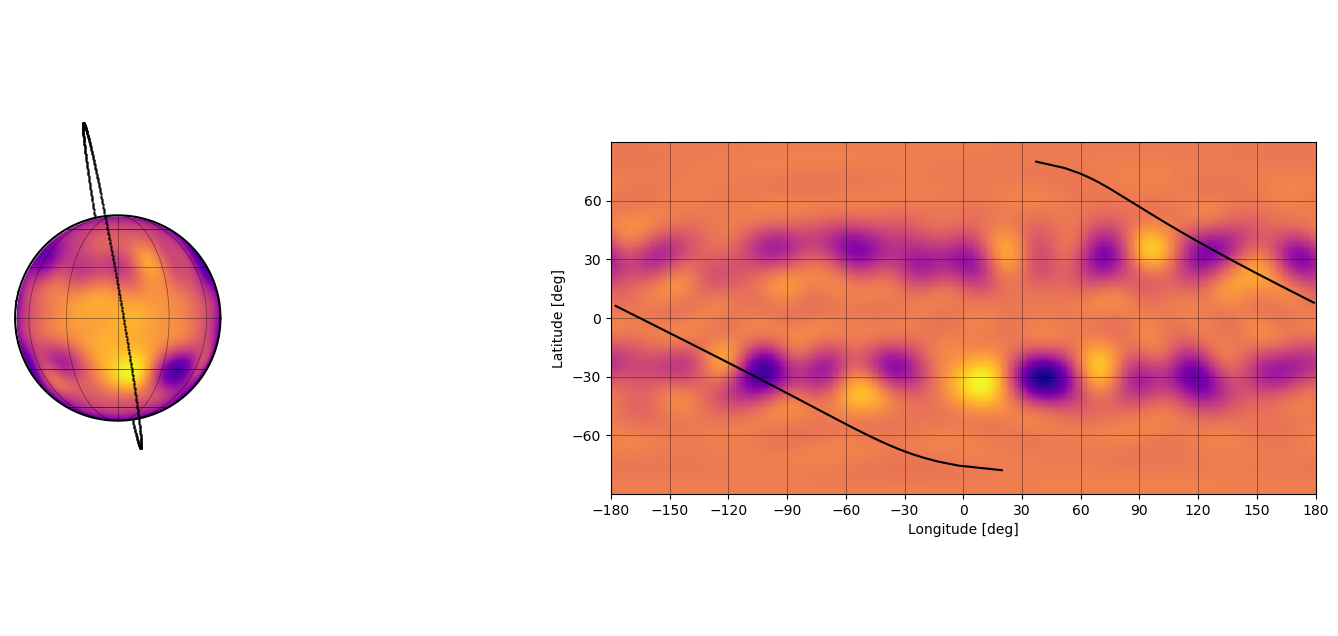

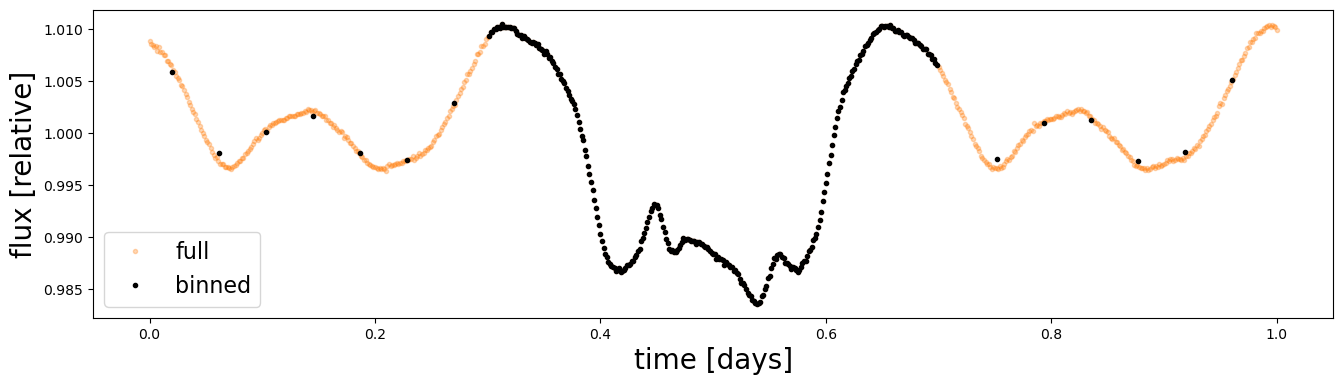

In [6]:
# *** True parameters & priors
params = {
    "planet.inc": {"truth": 88.0, "dist": Inclination},
    "planet.ecc": {"truth": 0.2, "dist": Uniform, "args": [0.0, 0.4]},
    "planet.Omega": {"truth": 100, "dist": Uniform, "args": [-180,180]},
    "planet.w": {"truth": 0.0, "dist": Angle},
    "planet.porb": {"truth": 1.0, "dist": Uniform, "args": [0.975, 1.025]},
    "planet.t0": {"truth": 0.5, "dist": Uniform, "args": [0.475, 0.525]},
    "planet.r": {"truth": 0.1, "dist": Uniform, "args": [0.06, 0.14]},
    "star.inc": {"truth": 90, "dist": Inclination},
    "star.m": {"truth": 0.5, "dist": Uniform, "args": [0.4, 0.6]},
    "star.u1": {"truth": 0.4, "dist": Uniform, "args": [0.0, 0.6]},
    "star.u2": {"truth": 0.2, "dist": Uniform, "args": [0.0, 0.4]},
    "star.prot": {"truth": 0.34, "dist": pm.Uniform, "args": [0.1, 1.0]},
    "gp.r": {"truth": 10, "dist": Uniform, "args": [5.0, 25.0]},
    "gp.c": {"truth": 0.1, "dist": Uniform, "args": [0.01, 0.5]},
    "gp.n": {"truth": 20, "dist": Uniform, "args": [1, 30]},
    "gp.mu": {"truth": 30, "dist": Uniform, "args": [0.0, 80.0]},
    "gp.sigma": {"truth": 5, "dist": Uniform, "args": [1.0, 10]},
    "gp.norm": {"truth": 1, "dist": Uniform, "args": [0.8, 1.2]}
}

# *** Time array (1 day @ 2 min cadence)
t = np.arange(0, 1, 2 / 24 / 60)

# Get the light curve
flux, err, med_flux = generate(t, params, error=1e-4)

# Get the binned light curve
t_, flux_, err_ = bin_out_of_transit(t, flux, err, params, dt=0.2)

# Plot the data
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(t, flux, "C1.", alpha=0.3, label="full")
ax.plot(t_, flux_, "k.", label="binned")
ax.set_ylabel("flux [relative]", fontsize=20)
ax.set_xlabel("time [days]", fontsize=20)
ax.legend(fontsize=16);

In [7]:
params['gp.norm']['truth'] = med_flux

# Inference

In [8]:
# Set some free params & get the model
p = dict(params)
p["gp.mu"]["free"] = True
p["gp.sigma"]["free"] = True
p["gp.n"]["free"] = True
p["gp.c"]["free"] = True
p["gp.r"]["free"] = True
p["gp.norm"]["free"] = True

p["planet.inc"]["free"] = True
p["planet.Omega"]["free"] = True
p["planet.w"]["free"] = True
p["planet.t0"]["free"] = True
p["planet.porb"]["free"] = True
p["planet.r"]["free"] = True
p["planet.ecc"]["free"] = True


free = [x for x in p.keys() if p[x].get("free", False)]
model = gp_model(t, flux, err, p)

In [9]:
from starry_process import MCMCInterface

with model:
    mci = MCMCInterface()

In [10]:
x = mci.optimize()
print(mci.transform(x, varnames=free))

optimizing logp for variables: [gp.norm, gp.n, gp.c, gp.r, gp.sigma, gp.mu, planet.r, planet.t0, planet.porb, planet.w, planet.Omega, planet.ecc, planet.inc]


message: Desired error not necessarily achieved due to precision loss.
logp: 5435.588184901907 -> 5463.003894511831


100%|██████████| 1/1 [00:00<00:00, 10.81it/s]

[8.93323037e+01 1.93037304e-01 1.06168878e+02 6.07877303e-03
 9.98480411e-01 4.99795563e-01 1.00788827e-01 1.07251935e+01
 9.70524604e-02 1.13884155e+01 2.77265501e+01 3.12398741e+00
 9.64291917e-01]


In [11]:
nwalkers = 30
p0 = mci.get_initial_state(nwalkers)

In [12]:
mci.logp(x)

array(5463.00389451)

# Sampling

In [28]:
import emcee

# Number of parameters
ndim = p0.shape[1]

# Instantiate the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, mci.logp)

# Run the chains
np.random.seed(0)
nsteps = 4000
state = sampler.run_mcmc(p0, nsteps, progress=True, store=True)

100%|██████████| 4000/4000 [2:36:26<00:00,  2.35s/it]  


In [29]:
max_n = 4000
n_inc = 1

# We'll track how the average autocorrelation time estimate changes
index = 0
ave_logp = np.empty(max_n)

# Now we'll sample for up to max_n steps
for sample in sampler.sample(p0, iterations=max_n, progress=True):
    # Only check convergence every n_inc steps
    if sampler.iteration % n_inc:
        continue
    
    L = sampler.get_log_prob()
    ave_logp[index] = np.mean(L)
    index += 1

100%|██████████| 4000/4000 [2:35:29<00:00,  2.33s/it]  


In [30]:
index

4000

Text(0, 0.5, 'mean logp')

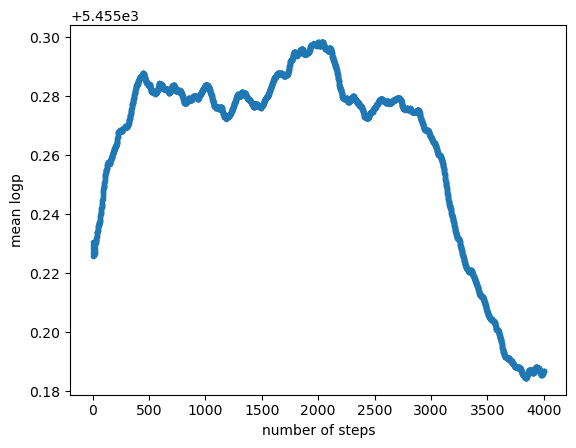

In [31]:
n = np.arange(1, index + 1)
y = ave_logp[:index]
plt.plot(n, y, '.')
plt.xlabel("number of steps")
plt.ylabel('mean logp')

In [32]:
sampler.reset()

In [33]:
def run_sampler_to_convergence(sampler, xs, nsamp):
    while True:
        sampler.reset()
        sampler.run_mcmc(xs, int(round(nsamp/2)), progress=True)
        xs = sampler.chain[:,-1,:]
        mean_lnprobs = np.mean(sampler.lnprobability, axis=0)

        if mean_lnprobs[-1] < mean_lnprobs[0]:
            break

    # Burned in, at least in the likelihood
    nfac = 1
    while True:
        xs = sampler.chain[:,-1,:]
        sampler.reset()
        sampler.run_mcmc(xs, nsamp, progress=True, thin_by=nfac)

        ac = sampler.get_autocorr_time(quiet=True)

        ac = np.max(ac)

        Nact = nsamp / ac

        if Nact > 50:
            break
        nfac *= 2

    return sampler

In [34]:
sampler_new = run_sampler_to_convergence(sampler, p0, nsteps)

100%|██████████| 4000/4000 [2:36:01<00:00,  2.34s/it]  
The chain is shorter than 50 times the integrated autocorrelation time for 14 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 80;
tau: [307.60824315 333.59247558 318.77070209 290.08881284 286.75626912
 236.88237509 296.91810919 258.72663741 276.46512629 284.17863017
 226.941811   260.25939395 260.28822502 325.08660573]
100%|██████████| 8000/8000 [5:12:30<00:00,  2.34s/it]  
The chain is shorter than 50 times the integrated autocorrelation time for 14 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 80;
tau: [290.55967581 328.79009078 307.95722617 236.30185964 246.24118547
 238.69471194 275.49790687 206.39414855 247.31465802 217.10070026
 221.23105747 222.38578522 212.92754166 264.81615026]
100%|██████████| 16000/16000 [10:14:21<00:00,  2.30s/it] 
The chain is shorter than 50 times the integrated autocorrelation time for 14 parameter(s). Use this estimate with caution and run a

emcee: Exception while calling your likelihood function:
  params: [-2.80352333e-01 -1.33908286e+00 -5.17473229e-01 -1.86594144e+00
 -8.74910294e-01 -6.47914000e-01  5.66508231e-02 -2.82189651e-02
  7.47830073e-02  4.14340407e-02  3.29265592e+00  1.38416769e+00
 -1.49904911e-01  8.93172862e+01]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

# What I had before

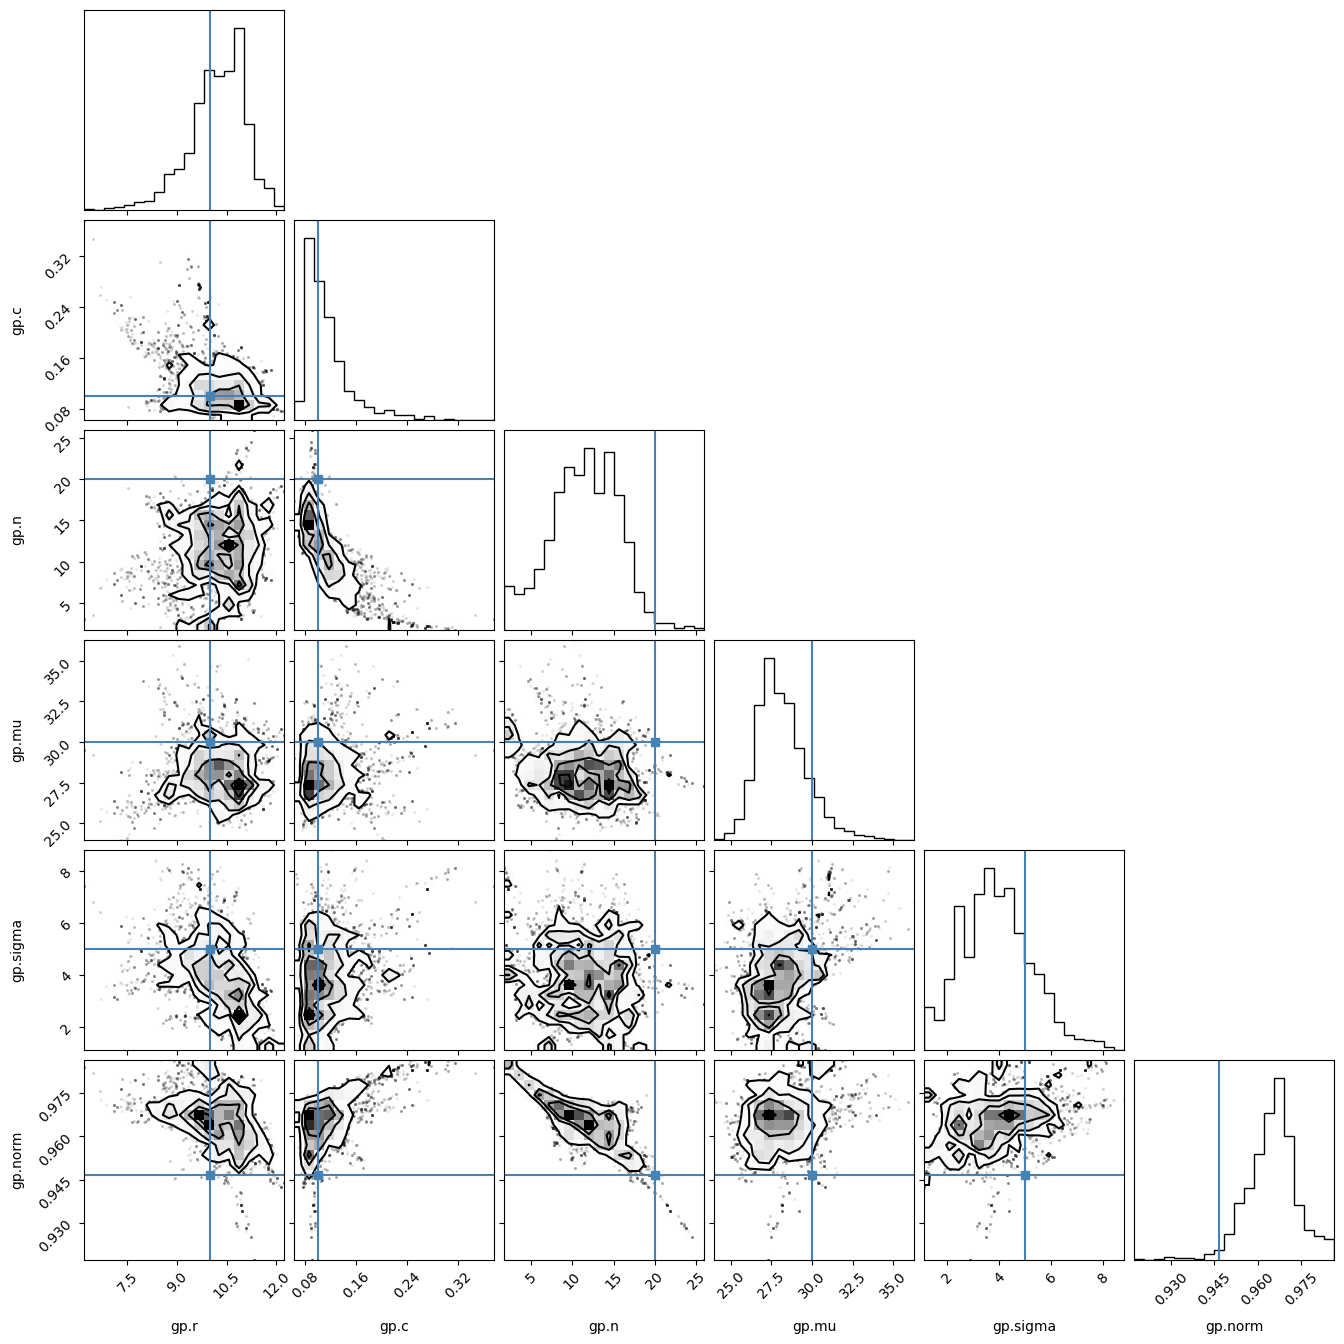

In [35]:
corner(np.array(samples[:,7:]), labels=free[7:], truths=[params[x]["truth"] for x in free[7:]]);

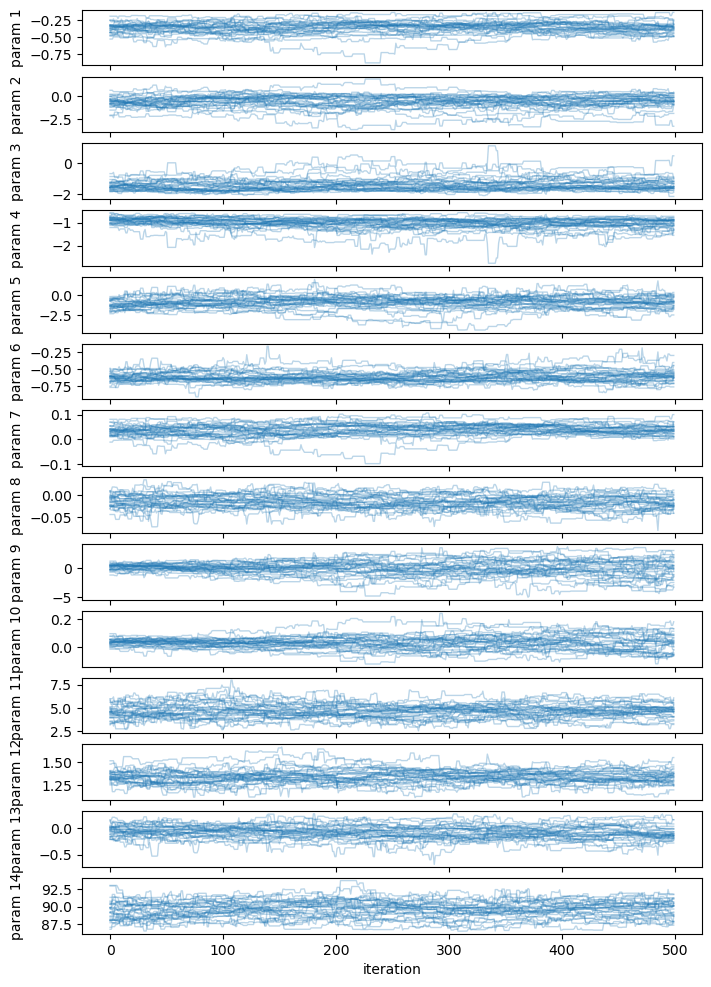

In [25]:
# Plot the walkers
fig, ax = plt.subplots(ndim, figsize=(8, 12), sharex=True)
for j in range(ndim):
    for k in range(nwalkers):
        ax[j].plot(sampler.chain[k, :, j], "C0-", lw=1, alpha=0.3)
    ax[j].set_ylabel("param {}".format(j + 1))
ax[-1].set_xlabel("iteration")
fig.align_ylabels(ax)
plt.show()

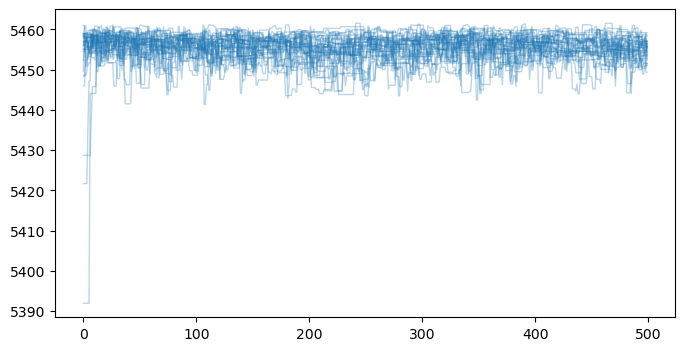

In [26]:
fig, ax = plt.subplots(1, figsize=(8, 4))
for k in range(nwalkers):
    plt.plot(sampler.lnprobability[k], "C0-", lw=1, alpha=0.3)